<a href="https://colab.research.google.com/github/PashaIanko/Kaggle.CrowdCounting/blob/saving_training_output/1_model_comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from google.colab import drive
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from abc import ABC, abstractmethod

# PEP8 standard

In [1]:
%%capture 
try: 
    from nbpep8.nbpep8 import pep8 
except ModuleNotFoundError: 
    !pip install pycodestyle 
    !pip install --index-url https://test.pypi.org/simple/ nbpep8
from nbpep8.nbpep8 import pep8

# Custom packages

In [2]:
%%capture
def download_files(url_dict):
    for file, url in url_dict.items():
        print(f'Downloading {file}')
        !wget -O {file} {url} {file}

git_download_path = \
'https://raw.githubusercontent.com/PashaIanko/Sklearn-Utils/main/'

files = [
    'path_manager.py',
    'sklearn_transformers.py',
    'sklearn_utils.py'
]

url_dict = {file: git_download_path + file for file in files}
download_files(url_dict)

In [3]:
import importlib
import path_manager
import sklearn_utils

def reload_all(modules_list_):
    for module in modules_list_:
        importlib.reload(module)

reload_all(
    [
        path_manager,
        sklearn_utils
        # other modules
    ]
)

from path_manager import PathManager

# Setup paths

In [5]:
drive.mount('/content/gdrive', force_remount=True)
gdrive_path = '/content/gdrive/MyDrive/'

PREPROC_TRIAL = 1
MODELS_TRIAL = 1
COMPETITION_PATH = gdrive_path + 'ML/Competitions/7.CrowdCounting/'

manager = PathManager(
    competition_path=COMPETITION_PATH,
    preprocessing_trial=PREPROC_TRIAL,
    models_trial=MODELS_TRIAL
)

manager.setup_paths()

Mounted at /content/gdrive
/content/gdrive/MyDrive/ML/Competitions/7.CrowdCounting/Data/preproc_trial_1 already exists
/content/gdrive/MyDrive/ML/Competitions/7.CrowdCounting/Models/trial_1 already exists


# Helper functions

# Data split

In [10]:
frames_directory = os.path.join(manager.data_root_path, 'frames')
labels_df = pd.read_csv(os.path.join(manager.data_root_path, 'labels.csv'))
labels_df['image_name'] = labels_df['id'].map('seq_{:06d}.jpg'.format)
print(labels_df.head(1))

   id  count      image_name
0   1     35  seq_000001.jpg


In [13]:
TRAINVAL_SIZE = 0.2  # 0.8
RANDOM_STATE = 42

trainval_labels_df, test_labels_df = train_test_split(
    labels_df,
    train_size=TRAINVAL_SIZE,
    random_state=RANDOM_STATE,
)
trainval_labels_df.shape, test_labels_df.shape

((400, 3), (1600, 3))

# Classes definition

In [21]:
from tensorflow.keras.models import Model

class NNModel(ABC):
    def __init__(
        self,
        name_,
        input_image_size_,
        validation_split_,
        batch_size_,
        trainval_labels_df_,
        test_labels_df_
    ):
        self.random_state = 42
        self.name = name_
        self.input_image_size = input_image_size_
        self.validation_split = validation_split_
        self.batch_size = batch_size_


        self.data_generator_parameters = None
        self.train_generator = None
        self.validation_generator = None
        self.test_generator = None
        self.model = None
        self.init_data_generator_parameters()
        self.init_data_generators(
            trainval_labels_df_,
            test_labels_df_
        )
    
    def __repr__(self):
        return f'''
            {
                self.random_state,
                self.name,
                self.input_image_size,
                self.validation_split,
                self.batch_size
            }
        '''
    @abstractmethod
    def init_data_generator_parameters(self):
        # Augmentation / preprocessing parameters
        pass
    
    def init_data_generators(self, trainval_labels_df_, test_labels_df_):
        trainval_data_generator = ImageDataGenerator(
            **self.data_generator_parameters,
            validation_split=self.validation_split)

        test_data_generator = ImageDataGenerator(
            **self.data_generator_parameters)
        
        common_flow_params = dict(
            directory=frames_directory,
            x_col='image_name',
            y_col='count',
            target_size=self.input_image_size,
            color_mode='rgb',
            class_mode='raw',
            batch_size=self.batch_size,
            shuffle=True,
            seed=self.random_state
        )

        self.train_generator = trainval_data_generator.flow_from_dataframe(
            **common_flow_params,
            subset='training',
            dataframe=trainval_labels_df_
        )

        self.validation_generator = trainval_data_generator.flow_from_dataframe(
            **common_flow_params,
            subset='validation',
            dataframe=trainval_labels_df_
        )

        self.test_generator = test_data_generator.flow_from_dataframe(
            **common_flow_params,
            dataframe=test_labels_df_
        )

    def visualize_data(self):
        X_batch, Y_batch = next(self.train_generator)
        print(X_batch.shape, np.max(X_batch), np.min(X_batch))

        _, ax = plt.subplots(3, 3)
        ax = ax.flatten()
        for i in range(9):
            ax[i].imshow(X_batch[i])
            ax[i].set_title(Y_batch[i])
            ax[i].axis('off')

        _, ax_hist = plt.subplots()
        ax.hist.hist(Y_batch)
        
    @abstractmethod
    def prepare_model(self):
        pass

    def compile_model(self):
        self.model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
            loss='mse',
            metrics=['mse', 'mae']
        )

    def unfreeze_n_layers(self, n_layers_to_freeze_):
        assert n_layers_to_freeze_ > 0

        for layer in self.model.layers[:-n_layers_to_freeze_]:
            layer.trainable = False
        for layer in self.model.layers[-n_layers_to_freeze_:]:
            layer.trainable = True
    
    def fit(self, epochs_, callbacks_):
        self.learning_history = self.model.fit_generator(
            self.train_generator,
            validation_data=self.validation_generator,
            epochs=epochs_,
            callbacks=callbacks_
        )
        return self.learning_history

In [22]:
from tensorflow.keras.applications import resnet50
import tensorflow as tf
from tensorflow.keras.layers import (
    Dense,
    Dropout,
    Flatten,

)

class ResNetModel(NNModel):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
    
    def init_data_generator_parameters(self):
        
        self.data_generator_parameters = dict(
            rescale=None,  # 1./255,
            preprocessing_function=tf.keras.applications.resnet50.preprocess_input
        )
    
    def prepare_model(self):
        feature_extractor = resnet50.ResNet50(
            weights='imagenet',
            pooling='avg',
            input_shape=(224, 224, 3),
            include_top=False
        )
        x = feature_extractor.output
        x = Dense(units=400, activation='relu')(x)
        x = Dropout(0.3)(x)
        x = Dense(units=400, activation='relu')(x)
        x = Dropout(0.3)(x)
        outputs = Dense(units=1, activation='linear')(x)

        self.model = Model(
            inputs=feature_extractor.input,
            outputs=outputs
        )

# ResNet baseline evaluation

In [23]:
resnet = ResNetModel(
    name_='resnet',
    input_image_size_=(224, 224),
    validation_split_=0.95,  # fraction of images, reserved for validation
    batch_size_=64,
    trainval_labels_df_=trainval_labels_df,
    test_labels_df_=test_labels_df
)

resnet.prepare_model()
resnet.compile_model()

Found 20 validated image filenames.
Found 380 validated image filenames.
Found 1600 validated image filenames.
94765736/94765736 [==============================] - 4s 0us/step


In [24]:
resnet.model.load_weights(
    os.path.join(
        manager.models_trial_path,
        resnet.name,
        resnet.name
    )
)

In [26]:
resnet.model.evaluate(resnet.validation_generator)

6/6 [==============================] - 201s 37s/step - loss: 934.9418 - mse: 934.9418 - mae: 29.8802


[934.9417724609375, 934.9417724609375, 29.880239486694336]

In [36]:
def plot_history(csv_filepaths_dict_, metrics_):
    _, ax = plt.subplots()

    for model_name, path in csv_filepaths_dict_.items():
        assert os.path.isfile(path)
        df = pd.read_csv(path)
        ax.plot(df[metrics_], label=f'{model_name} {metrics_}')
        ax.plot(df[f'val_{metrics_}'], label=f'{model_name} val_{metrics_}')
    
    ax.set_ylabel(f'Learning curve for {metrics_}')
    ax.set_xlabel(f'Epoch')
    ax.grid()
    ax.legend()

   Unnamed: 0        loss         mse        mae    val_loss     val_mse  \
0           0  910.997742  910.997742  29.431988  969.539856  969.539856   
1           1  904.507629  904.507629  29.327351  960.773621  960.773621   
2           2  879.655457  879.655457  28.979349  952.098755  952.098755   
3           3  905.028137  905.028137  29.345654  943.493408  943.493408   
4           4  884.234070  884.234070  28.964701  934.941711  934.941711   

     val_mae     lr  
0  30.450390  0.001  
1  30.306944  0.001  
2  30.164328  0.001  
3  30.022175  0.001  
4  29.880238  0.001  


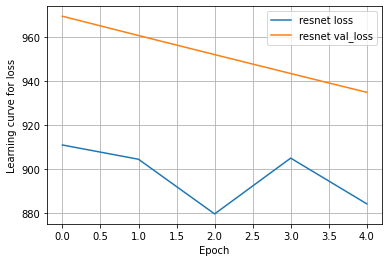

In [37]:
plot_history(
    {
        'resnet': os.path.join(manager.models_trial_path, 'resnet.csv')
    },
    metrics_='loss'
)